In [1]:
using PyPlot
using Seaborn
import JLD2
import Distributions

In [2]:
include("src\\NGSIM.jl")

update_params! (generic function with 1 method)

In [3]:
# td = load_trajdata(1);
JLD2.@load "td.jld" td
rd = NGSIM.ROADWAY_101

(S, id_lookup) = td_sparse(td)
;

In [122]:
fs = [
    s::VehicleState -> s.v * cos(s.posF.ϕ), 
    s::VehicleState -> s.v * sin(s.posF.ϕ),
    s::VehicleState -> length(rd[s.posF.roadind.tag.segment].lanes) - s.posF.roadind.tag.lane + 1
]

@time (hmm, hmm_data) = init_em_problem(S, fs, T=50_000);

  0.234254 seconds (402.34 k allocations: 44.001 MiB, 9.69% gc time)


In [111]:
include("src\\em.jl")

update_params! (generic function with 1 method)

In [27]:
NUM_ITERS = 30

30

In [124]:
@time for _ in 1:NUM_ITERS
    forward_backward_pass!(hmm, hmm_data)
    state_probs!(hmm, hmm_data)
    update_params!(hmm, hmm_data)
    
    # hack in convergence with differnce in A
    δ = sum(abs, old_A .- hmm.A)
    (δ ≤ 0.001) && break
    old_A = hmm.A
end

  4.510231 seconds (29.72 M allocations: 1.417 GiB, 9.73% gc time)


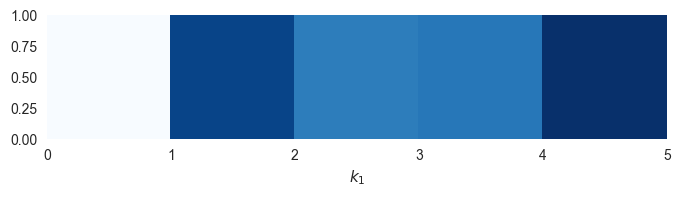

In [125]:
pcolor(reshape(hmm.π0, (1, hmm.K)), cmap=PyPlot.PyPlot.cm_get_cmap("Blues"))
xlabel(L"k_1")
gca()[:set_aspect]("equal")

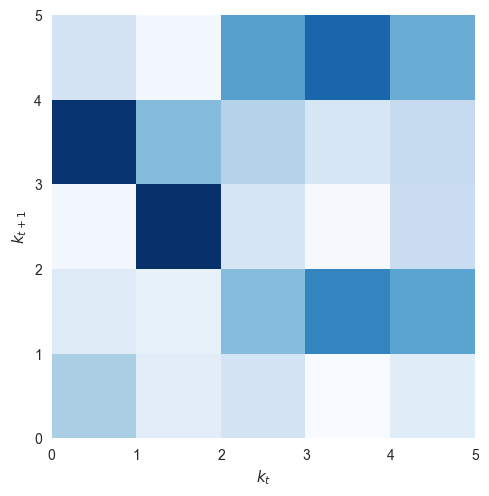

In [126]:
pcolor(hmm.A, cmap=PyPlot.PyPlot.cm_get_cmap("Blues"))
xlabel(L"k_t")
ylabel(L"k_{t+1}")
gca()[:set_aspect]("equal")

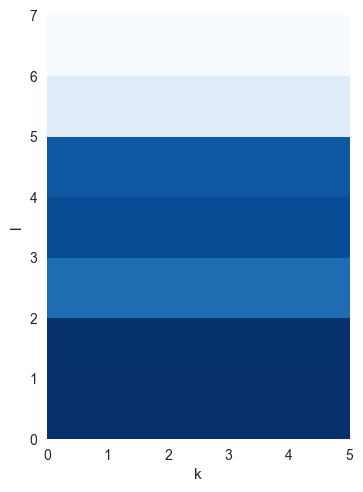

In [127]:
pcolor(hmm.bΔ, cmap=PyPlot.PyPlot.cm_get_cmap("Blues"))
xlabel("k")
ylabel("l")
gca()[:set_aspect]("equal")

In [131]:
hmm.c ./ sum(hmm.c, 1)

3×5 Array{Float64,2}:
 0.0459214  0.0396346  0.00150684  0.852946   0.0127853 
 0.800261   0.237171   0.600793    0.0832884  0.00124794
 0.153817   0.723195   0.3977      0.0637654  0.985967  

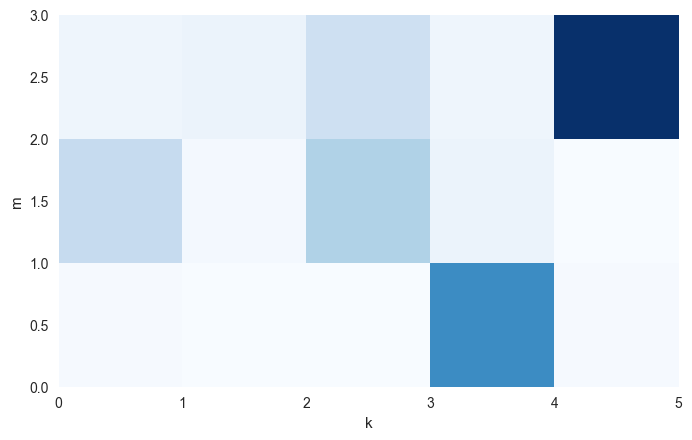

In [128]:
pcolor(hmm.c, cmap=PyPlot.PyPlot.cm_get_cmap("Blues"))
xlabel("k")
ylabel("m")
gca()[:set_aspect]("equal")

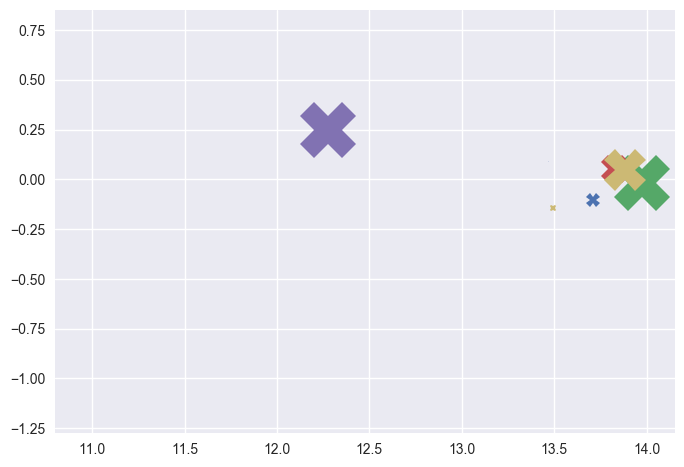

C:\Anaconda3\envs\conda_jl\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [51]:
fig = figure()
ax = fig[:gca]()

for k in 1:hmm.K
    clr=0
    for m in 1:hmm.M
        if m == 1
            l = plot(hmm.μs[1, m, k], hmm.μs[2, m, k], "X", markersize=40*hmm.c[m, k])
            clr = l[1][:get_color]()
        else
            plot(hmm.μs[1, m, k], hmm.μs[2, m, k], "X", markersize=20*hmm.c[m, k], c=clr)
        end
    end
end
legend(bbox_to_anchor=(1, 1))